# Predicting Games Rating Score

In this project we are applying machine learning algorithms to predicts VGChartz rating scores for games. To achinve the best result possible we need to pick the best model that fit the data. The algorithms that we are planning to use are Linear Rigresson, Lasso and Ridge.

## Imporing Libraries

In [42]:
from utilities.VGChartz import get_games_data
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from rich import print
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures


from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression,LassoCV,RidgeCV

from sklearn.model_selection import cross_val_score, train_test_split,KFold, GridSearchCV


## Get VGChartz data 
by calling `get_games_data` which scrap the data from VGChartz if the `/data/VGChartz.csv` file is not exsist.

In [43]:
df = get_games_data()

## Cleaning VGChartz Data

In [44]:
# Creating new Feature called Score by taking the average of the three type of scores
temp = df[['VGChartz Score', 'Critic Score', 'User Score']]
temp=temp.T.fillna(temp.T.mean()).T
df[['VGChartz Score', 'Critic Score', 'User Score']] = temp
df['Score'] = (df['VGChartz Score'] +df['Critic Score'] + df['User Score'])/3
df =df.dropna(subset=['Score'])

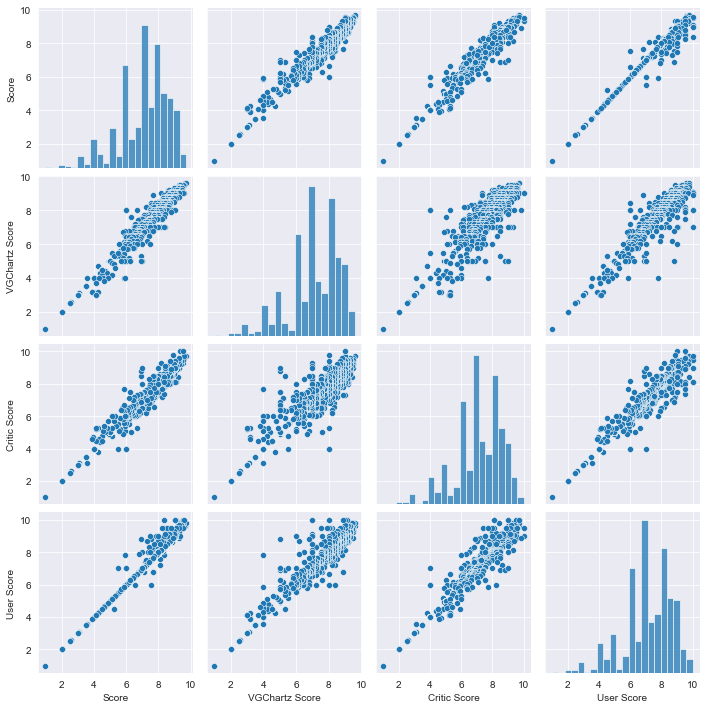

In [45]:
sns.pairplot(df[['Score', 'VGChartz Score', 'Critic Score', 'User Score']])

## Spliting Features for testing the corralation

In [46]:
df_scores = df.copy(deep=True)
df_genre = df.copy(deep=True)
df_console = df.copy(deep=True)
df_scores_genre_console = df.copy(deep=True)

In [47]:
df_scores = df_scores[['Score', 'VGChartz Score', 'Critic Score', 'User Score']]
df_genre = pd.get_dummies(df_genre[['Score','VGChartz Score', 'Genre']], columns=['Genre'])
df_console = pd.get_dummies(df_console[['Score', 'VGChartz Score','Console']], columns=['Console'])
df_scores_genre_console = pd.get_dummies(df_scores_genre_console[['Score','VGChartz Score','Genre', 'Console']], columns=['Console', 'Genre'])

<AxesSubplot:ylabel='Score'>

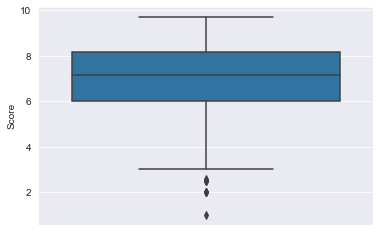

In [52]:

sns.boxplot(y=df_scores['Score'])

In [57]:
df_scores_genre_console

,Score,VGChartz Score,Console_3DS,Console_DS,Console_DSiW,Console_GC,Console_NS,Console_PC,Console_PS2,Console_PS3,...,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Genre_Visual Novel
0,9.633333,9.6,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,9.700000,9.6,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,9.500000,9.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.550000,9.5,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,9.300000,9.5,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,2.000000,2.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1176,2.000000,2.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1177,1.000000,1.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1178,4.500000,4.5,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [76]:
filter_col = [col for col in df_scores_genre_console if col.startswith('Genre_')]
filter_col
df_scores_genre_console.groupby(filter_col).sum()

Score  \
Genre_Action Genre_Action-Adventure Genre_Adventure Genre_Education Genre_Fighting Genre_Misc Genre_Music Genre_Party Genre_Platform Genre_Puzzle Genre_Racing Genre_Role-Playing Genre_Sandbox Genre_Shooter Genre_Simulation Genre_Sports Genre_Strategy Genre_Visual Novel                
0            0                      0               0               0              0          0           0           0              0            0            0                  0             0             0                0            0              1                     31.000000   
                                                                                                                                                                                                                                            1              0                    408.800000   
                                                                                                                                                                                                                               1            0              0                    341.583333   
                                                                                                                                                                                                              1                0            0              0                    161.466667   
                                                                                                                                                                                                1             0                0            0              0                    967.316667   
                                                                                                                                                                                  1             0             0                0            0              0                      7.000000   
                                                                                                                                                               1                  0             0             0                0            0              0                   1240.583333   
                                                                                                                                                  1            0                  0             0             0                0            0              0                    400.366667   
                                                                                                                                     1            0            0                  0             0             0                0            0              0                    354.816667   
                                                                                                                      1              0            0            0                  0             0             0                0            0              0                    728.833333   
                                                                                                          1           0              0            0            0                  0             0             0                0            0              0                     30.600000   
                                                                                              1           0           0              0            0            0                  0             0             0                0            0              0                     40.950000   
                                                                                   1          0           0           0              0            0            0                  0             0             0                0            0              0                    3

<AxesSubplot:xlabel='Count', ylabel='Score'>

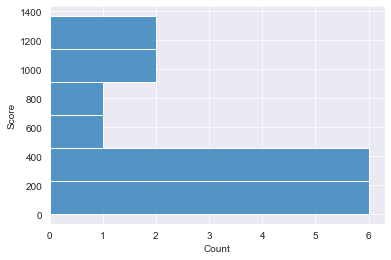

In [72]:
sns.histplot(y=df_scores_genre_console.groupby(filter_col).sum())

In [28]:
def linear_regression_score(X, y, kfold:int=5, scoring_type:str='r2'):
    lm = LinearRegression()
    result = cross_val_score(lm, X, y, cv=kfold, scoring=scoring_type)
    return np.mean(result)

def lasso_score(X, y, X_val,y_val ,kfold:int=5, scoring_type:str='r2'):
    alphas = 10**np.linspace(6,-2,50)*0.5
    lasso = Lasso(max_iter=10000, normalize=True)
    
    lassocv = LassoCV(alphas=None, cv=kfold, max_iter=100000, normalize=True)
    lassocv.fit(X_val, y_val)
    lasso.set_params(alpha=lassocv.alpha_)
    clf = Lasso(alpha=lassocv.alpha_)
    scores = cross_val_score(clf, X, y, cv=kfold)
    return scores.mean()
    
def riggid_score(X,y,X_val,y_val,kfold:int=5):
    alphas = 10**np.linspace(6,-2,50)*0.5
    ridgecv = RidgeCV(alphas=alphas, normalize=True)
    ridgecv.fit(X_val, y_val)
    ridge6 = Ridge(alpha=ridgecv.alpha_, normalize=True)
    ridge6.fit(X, y)
    score = cross_val_score(ridge6, X, y, cv=kfold)
    return score.mean()
    
def poly_score(X,y,X_val,y_val,degree:int=2,kfold:int=5):
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X_val)
    poly = LinearRegression()
    return np.mean(cross_val_score(poly, X_poly, y_val, cv=kfold))

In [37]:
def find_scores(df):
#     kfold = KFold(n_splits=20, shuffle=True, random_state=0)
    X, X_test, y, y_test = train_test_split(df.loc[:, df.columns != 'Score'], df['Score'], test_size=0.25, random_state=64)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=64)
    linear_score = linear_regression_score(X_train, y_train)
    lassov_score = lasso_score(X_train, y_train,X_val,y_val,kfold=10)
    riggidv_score = riggid_score(X_train, y_train,X_val,y_val,kfold=10)
    polyv_score = poly_score(X_train, y_train,X_val,y_val,degree=3,kfold=10)
    return {'Linear Score':linear_score,'Lasso Score':lassov_score,'Riggid Score':riggidv_score,'Polynomial Score':polyv_score}

In [38]:
dfScores=pd.DataFrame({'Scores':find_scores(df_scores),
                       'Genre':find_scores(df_genre),
                       'Console':find_scores(df_console),
                       'SGC':find_scores(df_scores_genre_console)}).T
dfScores

,Linear Score,Lasso Score,Riggid Score,Polynomial Score
Scores,1.000000e+00,1.000000,0.999997,1.000000e+00
Genre,9.442366e-01,0.944249,0.943922,9.549370e-01
Console,9.436197e-01,0.943750,0.943375,-3.238729e+18
SGC,-1.580799e+20,0.943437,0.942274,-1.198432e+20


In [12]:
df4.corr()

,Score,VGChartz Score,Console_3DS,Console_DS,Console_DSiW,Console_GC,Console_NS,Console_PC,Console_PS2,Console_PS3,...,Genre_Platform,Genre_Puzzle,Genre_Racing,Genre_Role-Playing,Genre_Sandbox,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Genre_Visual Novel
Score,1.000000,0.978594,0.010680,0.073198,-0.006690,0.059963,-0.164689,-0.043053,0.040949,0.190729,...,0.068952,-0.000070,0.066767,0.090732,-0.001899,0.029395,-0.007265,0.002703,0.030535,-0.092902
VGChartz Score,0.978594,1.000000,0.014400,0.083406,-0.023186,0.055192,-0.185545,-0.035257,0.049480,0.190349,...,0.061596,0.001863,0.066726,0.090297,-0.001237,0.034198,-0.010426,0.003111,0.033015,-0.089285
Console_3DS,0.010680,0.014400,1.000000,-0.015676,-0.003305,-0.002697,-0.032568,-0.023036,-0.006909,-0.020673,...,-0.019702,-0.013770,-0.014196,0.048297,-0.001906,-0.023433,-0.009229,-0.013479,-0.014611,-0.004679
Console_DS,0.073198,0.083406,-0.015676,1.000000,-0.012132,-0.009902,-0.119569,-0.084575,-0.025364,-0.075900,...,-0.031646,0.042339,-0.034049,0.127917,-0.006999,-0.062437,-0.006814,-0.030544,0.051968,-0.017180
Console_DSiW,-0.006690,-0.023186,-0.003305,-0.012132,1.000000,-0.002087,-0.025205,-0.017829,-0.005347,-0.016000,...,0.045744,-0.010657,-0.010987,-0.020574,-0.001475,-0.018136,-0.007143,-0.010432,-0.011308,-0.003622
Console_GC,0.059963,0.055192,-0.002697,-0.009902,-0.002087,1.000000,-0.020571,-0.014551,-0.004364,-0.013058,...,0.062224,-0.008698,-0.008967,-0.016792,-0.001204,0.050148,-0.005829,-0.008514,-0.009229,-0.002956
Console_NS,-0.164689,-0.185545,-0.032568,-0.119569,-0.025205,-0.020571,1.000000,-0.175707,-0.052694,-0.157683,...,0.088624,-0.062800,-0.087741,-0.062421,-0.014540,-0.044666,0.037276,0.015598,-0.031434,-0.005796
Console_PC,-0.043053,-0.035257,-0.023036,-0.084575,-0.017829,-0.014551,-0.175707,1.000000,-0.037272,-0.111534,...,-0.027800,0.019795,-0.050443,-0.019119,-0.010285,0.044270,0.067710,-0.045312,0.086713,0.012817
Console_PS2,0.040949,0.049480,-0.006909,-0.025364,-0.005347,-0.004364,-0.052694,-0.037272,1.000000,-0.033449,...,-0.002452,-0.022279,-0.022968,0.073484,-0.003084,-0.037914,-0.014932,-0.021810,-0.023641,-0.007571
Console_PS3,0.190729,0.190349,-0.020673,-0.075900,-0.016000,-0.013058,-0.157683,-0.111534,-0.033449,1.000000,...,-0.041901,-0.066668,0.102302,-0.001649,-0.009230,0.044739,-0.023332,0.069228,-0.042975,-0.022656
